In [9]:
import tqdm, tqdm.notebook
from pathlib import Path
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

tqdm.tqdm = tqdm.notebook.tqdm

In [10]:
# Set configurations
images = Path('datasets/tractor')
outputs = Path('outputs/tractor/')
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

In [11]:
references = [str(p.relative_to(images)) for p in (images / 'train/').iterdir()]
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2022/05/16 23:09:19 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/05/16 23:09:19 hloc INFO] Skipping the extraction.
[2022/05/16 23:09:19 hloc INFO] Found 465 pairs.
[2022/05/16 23:09:19 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/05/16 23:09:19 hloc INFO] Skipping the matching.


PosixPath('outputs/tractor/matches.h5')

In [12]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

[2022/05/16 23:09:21 hloc WARNING] The database already exists, deleting it.
[2022/05/16 23:09:21 hloc INFO] Creating an empty database...
[2022/05/16 23:09:21 hloc INFO] Importing images into the database...
[2022/05/16 23:09:29 hloc INFO] Importing features into the database...
100%|██████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1585.71it/s]
[2022/05/16 23:09:29 hloc INFO] Importing matches into the database...
100%|████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 1147.15it/s]
[2022/05/16 23:09:30 hloc INFO] Performing geometric verification of the matches...
[2022/05/16 23:09:55 hloc INFO] Running 3D reconstruction...
[2022/05/16 23:10:45 hloc INFO] Reconstructed 1 model(s).
[2022/05/16 23:10:45 hloc INFO] Largest model is #0 with 31 images.
[2022/05/16 23:10:45 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 31
	num_cameras = 31
	num_points3D = 5080
	num_observations = 13200
	mean_track_

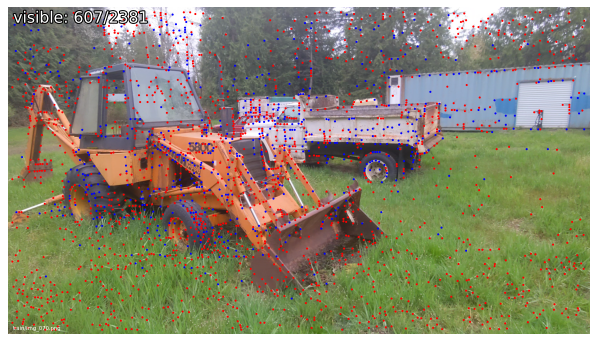

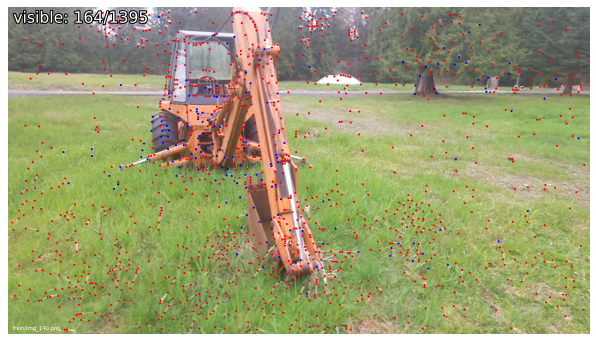

In [13]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

In [14]:
queries = [str(p.relative_to(images)) for p in (images / 'query/').iterdir()]
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=queries, feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=queries, ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2022/05/16 23:10:48 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


100%|██████████████████████████████████████████████████████████████| 123/123 [00:25<00:00,  4.77it/s]
[2022/05/16 23:11:13 hloc INFO] Finished exporting features.
[2022/05/16 23:11:13 hloc INFO] Found 3813 pairs.
[2022/05/16 23:11:13 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|████████████████████████████████████████████████████████████| 3813/3813 [04:28<00:00, 14.22it/s]
[2022/05/16 23:15:42 hloc INFO] Finished exporting matches.


found 171/1251 inlier correspondences.


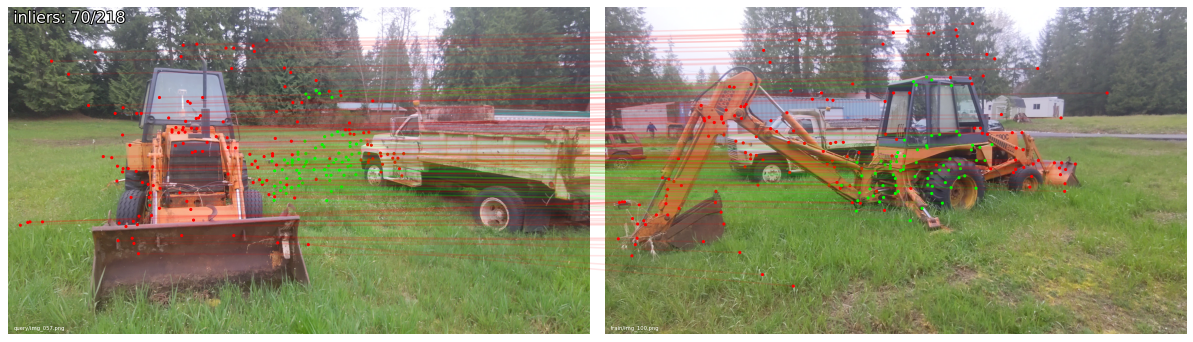

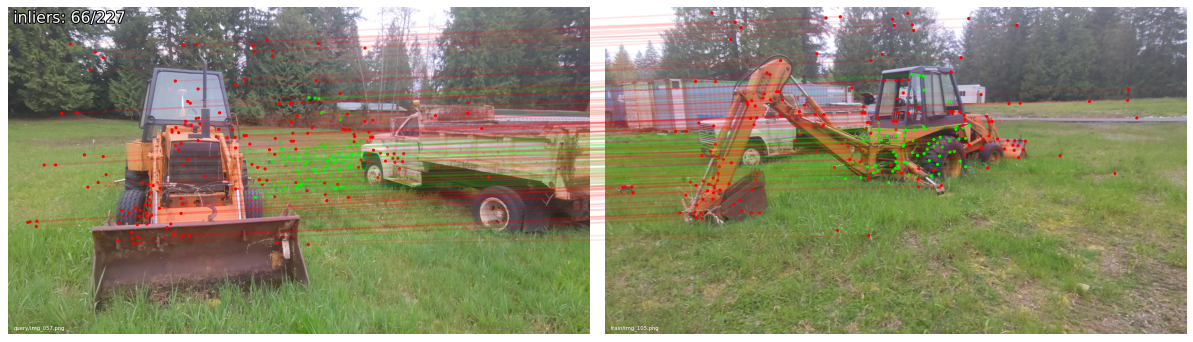

In [25]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / queries[0])
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}

localizer = QueryLocalizer(model, conf)
ret0, log0 = pose_from_cluster(localizer, queries[0], camera, ref_ids, features, matches)
print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, queries[0], log, model)

In [17]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=queries[0])
fig.show()

found 171/1251 inlier correspondences.


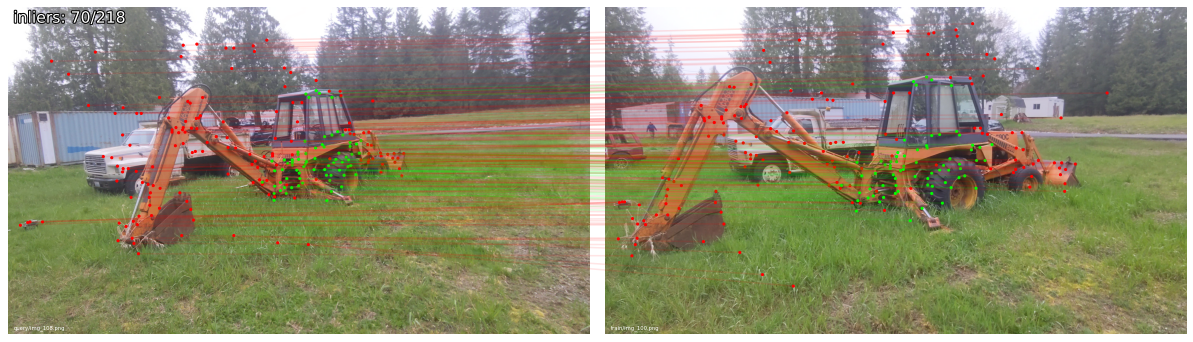

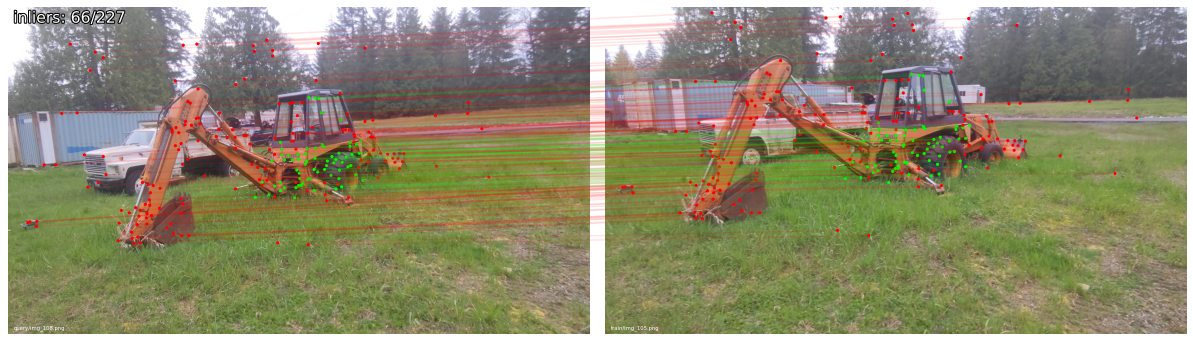

In [26]:
camera = pycolmap.infer_camera_from_image(images / queries[34])
ret1, log1 = pose_from_cluster(localizer, queries[34], camera, ref_ids, features, matches)
print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, queries[34], log, model)

In [22]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=queries[0])
fig.show()

In [32]:
t0 = ret0['tvec']
q0 = ret0['qvec']
t1 = ret1['tvec']
q1 = ret1['qvec']

In [36]:
print(f'Predicted pose 1: {t0}, {q0}')
print(f'Predicted pose 1: {t1}, {q1}')

Predicted pose 1: [-1.5805234  -0.76477845  6.74299181], [-0.41867481 -0.05277937  0.90351005  0.07480191]
Predicted pose 1: [-0.16911728 -0.47133302  5.868494  ], [0.60546694 0.02060742 0.7941766  0.04763039]


In [37]:
print(queries[0], queries[34])

query/img_057.png query/img_108.png
